In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('AirQualityUCI.csv')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [3]:
# Rename the columns to be more descriptive
data.rename(columns={
    'Date': 'Measurement_Date',
    'Time': 'Measurement_Time',
    'CO(GT)': 'Carbon_Monoxide_Concentration',
    'PT08.S1(CO)': 'CO_Sensor_Measurement',
    'NMHC(GT)': 'Non_Methane_Hydrocarbons_Concentration',
    'C6H6(GT)': 'Benzene_Concentration',
    'PT08.S2(NMHC)': 'NMHC_Sensor_Measurement',
    'NOx(GT)': 'Nitrogen_Oxides_Concentration',
    'PT08.S3(NOx)': 'NOx_Sensor_Measurement',
    'NO2(GT)': 'Nitrogen_Dioxide_Concentration',
    'T': 'Temperature_Celsius',
    'RH': 'Relative_Humidity',
    'AH': 'Absolute_Humidity'
}, inplace=True)

In [4]:
# Visualize the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Measurement_Date                        9357 non-null   object 
 1   Measurement_Time                        9357 non-null   object 
 2   Carbon_Monoxide_Concentration           9357 non-null   float64
 3   CO_Sensor_Measurement                   9357 non-null   float64
 4   Non_Methane_Hydrocarbons_Concentration  9357 non-null   float64
 5   Benzene_Concentration                   9357 non-null   float64
 6   NMHC_Sensor_Measurement                 9357 non-null   float64
 7   Nitrogen_Oxides_Concentration           9357 non-null   float64
 8   NOx_Sensor_Measurement                  9357 non-null   float64
 9   Nitrogen_Dioxide_Concentration          9357 non-null   float64
 10  PT08.S4(NO2)                            9357 non-null   floa

In [5]:
# Remove weird last two columns
data.drop(data.columns[15:17], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Measurement_Date                        9357 non-null   object 
 1   Measurement_Time                        9357 non-null   object 
 2   Carbon_Monoxide_Concentration           9357 non-null   float64
 3   CO_Sensor_Measurement                   9357 non-null   float64
 4   Non_Methane_Hydrocarbons_Concentration  9357 non-null   float64
 5   Benzene_Concentration                   9357 non-null   float64
 6   NMHC_Sensor_Measurement                 9357 non-null   float64
 7   Nitrogen_Oxides_Concentration           9357 non-null   float64
 8   NOx_Sensor_Measurement                  9357 non-null   float64
 9   Nitrogen_Dioxide_Concentration          9357 non-null   float64
 10  PT08.S4(NO2)                            9357 non-null   floa

In [25]:
# List columns with missing data
missing_data = data.isna().any()
columns_with_missing_data = missing_data[missing_data].index.tolist()
print(columns_with_missing_data)

['Measurement_Date', 'Measurement_Time', 'Carbon_Monoxide_Concentration', 'CO_Sensor_Measurement', 'Non_Methane_Hydrocarbons_Concentration', 'Benzene_Concentration', 'NMHC_Sensor_Measurement', 'Nitrogen_Oxides_Concentration', 'NOx_Sensor_Measurement', 'Nitrogen_Dioxide_Concentration', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'Temperature_Celsius', 'Relative_Humidity', 'Absolute_Humidity']


In [6]:
# After visual inspection, it looks like there are only 9358 entries in the csv file. Not sure why data.info() is registering 9471 
# data entries? Because of this, I will only "keep" the 9358 rows.
data = data[:9358]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9358 entries, 0 to 9357
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Measurement_Date                        9357 non-null   object 
 1   Measurement_Time                        9357 non-null   object 
 2   Carbon_Monoxide_Concentration           9357 non-null   float64
 3   CO_Sensor_Measurement                   9357 non-null   float64
 4   Non_Methane_Hydrocarbons_Concentration  9357 non-null   float64
 5   Benzene_Concentration                   9357 non-null   float64
 6   NMHC_Sensor_Measurement                 9357 non-null   float64
 7   Nitrogen_Oxides_Concentration           9357 non-null   float64
 8   NOx_Sensor_Measurement                  9357 non-null   float64
 9   Nitrogen_Dioxide_Concentration          9357 non-null   float64
 10  PT08.S4(NO2)                            9357 non-null   floa

In [7]:
# Isolate the numerical data columns
numerical_data = data.iloc[:, 2:15]

# The dataset notes that some measurements may be recorded as -200, indicating missing or invalid data points. I will remove 
# any -200 values and replace them with the mean value in the column.
numerical_data.replace(-200, pd.NA, inplace=True)

# Replace NaN values with the mean of each column
numerical_data.fillna(numerical_data.mean(), inplace=True)

/tmp/ipykernel_116023/1326664720.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numerical_data.fillna(numerical_data.mean(), inplace=True)


In [8]:
# Calculate the correlation of the target (Nitrogen Dioxide Concentration) with the other features
correlations = numerical_data.corrwith(numerical_data['Nitrogen_Dioxide_Concentration'])
print(correlations)

Carbon_Monoxide_Concentration             0.646349
CO_Sensor_Measurement                     0.562843
Non_Methane_Hydrocarbons_Concentration    0.156510
Benzene_Concentration                     0.535919
NMHC_Sensor_Measurement                   0.561180
Nitrogen_Oxides_Concentration             0.763074
NOx_Sensor_Measurement                   -0.569479
Nitrogen_Dioxide_Concentration            1.000000
PT08.S4(NO2)                              0.140655
PT08.S5(O3)                               0.629443
Temperature_Celsius                      -0.165466
Relative_Humidity                        -0.080569
Absolute_Humidity                        -0.291392
dtype: float64


In [15]:
# Showing strong correlation with the Carbon_Monoxide_Concentration, Nitrogen_Oxides_Concentration features

In [9]:
# Split the dataset into a train and test set using Nitrogen_Dioxide_Concentration as the target label
X = numerical_data.drop(columns=["Nitrogen_Dioxide_Concentration"])
y = numerical_data["Nitrogen_Dioxide_Concentration"]

# Implement a "binning" approach to simulate the benefits of stratified splitting in classification models. This
# will ensure the train/test splits are balanced with the same proportion of low/medium/high NO2 concentration values.
y_binned = pd.qcut(y, q=10, duplicates='drop') # divide y into 10 bins

# Split the data based on the created bins
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state=42)

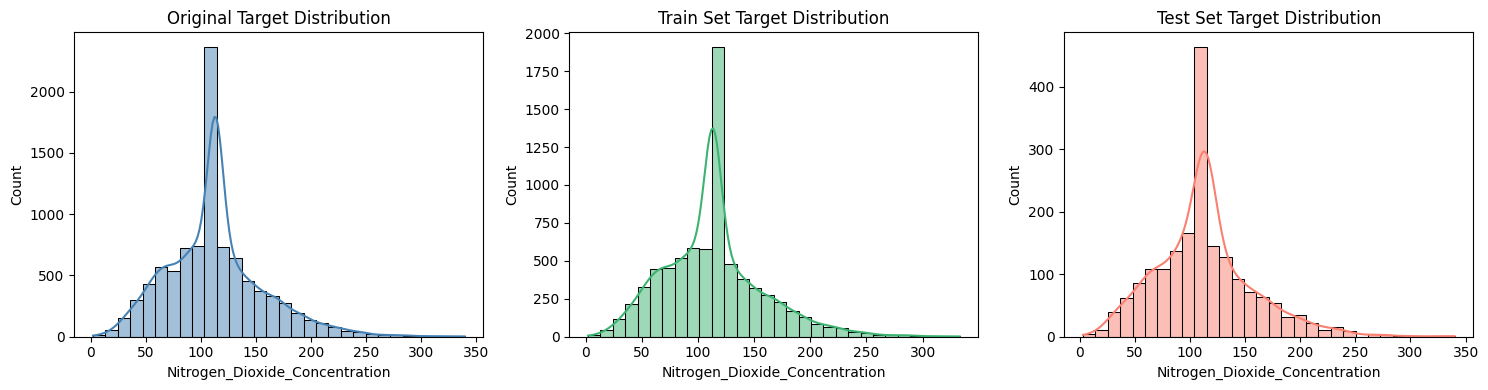

In [11]:
# Plot the original NO2 concentration distribution along with the train and test splits
plt.figure(figsize=(15, 4))

# Full dataset distribution
plt.subplot(1, 3, 1)
sns.histplot(y, kde=True, bins=30, color='steelblue')
plt.title("Original Target Distribution")

# Training set distribution
plt.subplot(1, 3, 2)
sns.histplot(y_train, kde=True, bins=30, color='mediumseagreen')
plt.title("Train Set Target Distribution")

# Test set distribution
plt.subplot(1, 3, 3)
sns.histplot(y_test, kde=True, bins=30, color='salmon')
plt.title("Test Set Target Distribution")

plt.tight_layout()
plt.show()

In [13]:
# Create RandomForestRegressor with 10 cross validation folds
forest_regressor = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': list(range(2, 21)),  # Min samples to split a node
    'min_samples_leaf': list(range(1, 11)),  # Min samples at a leaf node
}
# Set up the randomized search with 10 cross-validation folds, 100 combinations to try, and the negative mean squared error.
random_search = RandomizedSearchCV(
    estimator=forest_regressor,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
# Fit on the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [14]:
#Evaluate the model on the test set
final_predictions = random_search.best_estimator_.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, final_predictions)
rmse = root_mean_squared_error(y_test, final_predictions)  # RMSE
r2 = r2_score(y_test, final_predictions)

# Print results
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Mean Squared Error: 220.19941161832566
Root Mean Squared Error: 14.839117615893663
R² Score: 0.8871079963877988


In [18]:
relative_rmse = rmse / (numerical_data["Nitrogen_Dioxide_Concentration"].max() - numerical_data["Nitrogen_Dioxide_Concentration"].min())
print(f"Relative RMSE: {relative_rmse:.4f}")

Relative RMSE: 0.0439


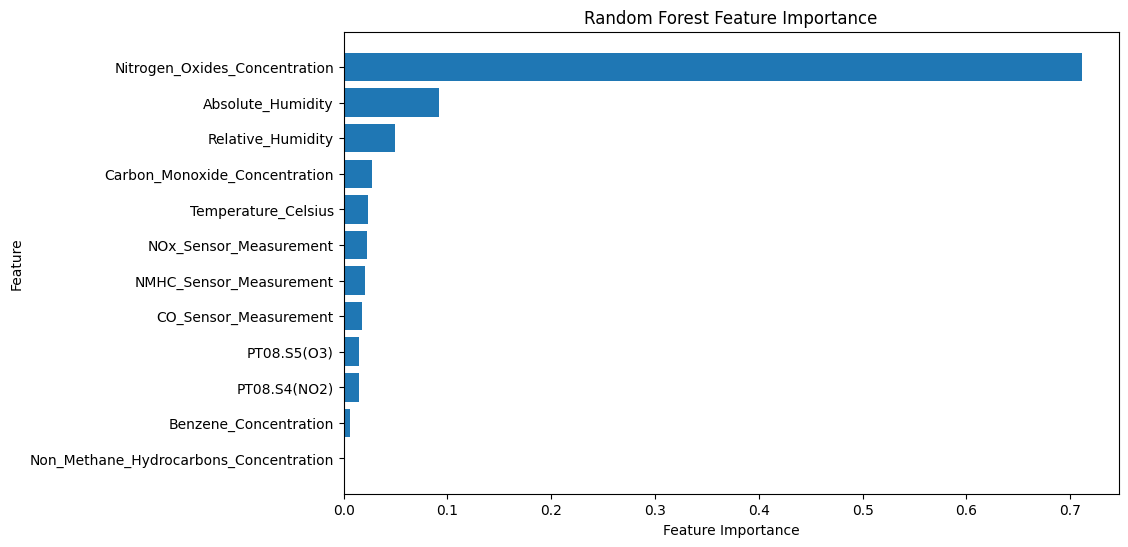

In [20]:
# Get the feature importance from the best estimator
feature_importances = random_search.best_estimator_.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()